In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow
from pprint import pprint

# Load Data, Don't Touch!!!

In [ ]:
stock_returns = pd.read_csv('stock_returns.csv', low_memory=False)

/var/folders/46/8kr9wdvj7hlgms2vc1hnj0z40000gn/T/ipykernel_5322/596341985.py:1: DtypeWarning: Columns (2,5,6,9,18,19,20,22,24,38,40,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  stock_returns = pd.read_csv('stock_returns.csv')


### Find all 308 tickers in the raw data, find returns

In [198]:
df = pd.read_csv('SP500_history.csv')
df['start'] = pd.to_datetime(df['start'])
df['ending'] = pd.to_datetime(df['ending'])
# Filter based on the criteria
filtered_list = df[(df['start'] < '2011-01-01') & (df['ending'] > '2022-12-31')]

# Get filtered returns
cols = ['PERMNO', 'date', 'TICKER', 'COMNAM', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 
 'BID', 'ASK', 'SHROUT', 'RETX', 'vwretd', 'vwretx', 'ewretd' , 'ewretx', 'sprtrn']
returns = stock_returns[
    (stock_returns['PERMNO'].isin(filtered_list['permno'])) &
    (pd.to_datetime(stock_returns['date']) <= pd.to_datetime('2022-12-31'))
][cols]

returns['date'] = pd.to_datetime(returns['date'])


In [199]:
# Find TICKERs that share the same PERMNO in returns
permno_ticker_counts = returns.groupby('PERMNO')['TICKER'].nunique()
shared_permnos = permno_ticker_counts[permno_ticker_counts > 1].index

# For each shared PERMNO, list all associated TICKERs
tickers_with_same_permno = returns[returns['PERMNO'].isin(shared_permnos)][['PERMNO', 'TICKER']].drop_duplicates().sort_values('PERMNO')
# pprint(tickers_with_same_permno[:50])
# For each shared PERMNO, set all TICKERs to the last (sorted) TICKER for that PERMNO
last_ticker_map = (
    tickers_with_same_permno.groupby('PERMNO')['TICKER']
    .last()
    .to_dict()
)
returns.loc[returns['PERMNO'].isin(shared_permnos), 'TICKER'] = returns.loc[returns['PERMNO'].isin(shared_permnos), 'PERMNO'].map(last_ticker_map)
ticker_counts = returns['TICKER'].value_counts()

returns = returns.drop_duplicates(['date','TICKER'])

len(returns['TICKER'].unique())

308

### Implied Vol  

In [ ]:
implied_volatility = pd.read_parquet('impl_vol_30.parquet', engine='pyarrow')

filtered_implied_vol = implied_volatility[
    (implied_volatility['date'] < pd.to_datetime('2022-12-31')) &
    (implied_volatility['ticker'].isin(returns['TICKER'].unique()))
]

# Merge avg_impl_vol from filtered_implied_vol into returns based on date and ticker
returns = returns.merge(
    filtered_implied_vol[['date', 'ticker', 'avg_impl_vol']],
    left_on=['date', 'TICKER'],
    right_on=['date', 'ticker'],
    how='left'
).drop(columns=['ticker'])

# Find rows in returns where avg_impl_vol is NA (missing)
na_impl_vol = returns[returns['avg_impl_vol'].isna()]
na_impl_vol['TICKER'].unique()
na_counts = na_impl_vol.groupby('TICKER').size().sort_values(ascending=False)

# Drop TICKERs with more than 10 missing avg_impl_vol values
tickers_to_drop = na_counts[na_counts > 10].index
returns = returns[~returns['TICKER'].isin(tickers_to_drop)]

# Fill remaining missing avg_impl_vol values with the last available value for each TICKER
returns['avg_impl_vol'] = returns.groupby('TICKER')['avg_impl_vol'].transform(lambda x: x.ffill().bfill())

# Save file

In [ ]:
# returns.to_csv('returns_cleaned.csv', index=False)

****************************************************************

# Load returns_299

In [3]:
returns = pd.read_csv(R'D:\Study\Spring 25\Optimization Modeling in Finance\Data\returns_299.csv')

# VIX

In [4]:
import yfinance as yf

vix = yf.download('^VIX', start='2011-01-01', end='2022-12-31')
vix = vix[['Close']].rename(columns={'Close': 'VIX'})
vix["VIX"] = vix["VIX"] / 100
vix.index = pd.to_datetime(vix.index)
pprint(vix)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price          VIX
Ticker        ^VIX
Date              
2011-01-03  0.1761
2011-01-04  0.1738
2011-01-05  0.1702
2011-01-06  0.1740
2011-01-07  0.1714
...            ...
2022-12-23  0.2087
2022-12-27  0.2165
2022-12-28  0.2214
2022-12-29  0.2144
2022-12-30  0.2167

[3020 rows x 1 columns]


# Calculate Correlation

In [5]:
returns["RET"] = np.log(returns["RET"] + 1)

In [6]:
# Use SPY500 as a proxy
start, end = "2010-12-31", "2022-12-31"

idx = (
    yf.download("^GSPC",
                start=start,
                end=end,
                progress=False)
      .loc[:, ["Close"]]
      .rename(columns={"Close": "idx_price"})
)

idx['idx_ret'] = idx['idx_price'].pct_change()
idx["idx_ret"] = np.log(idx['idx_ret'] + 1)
idx = (
    idx
    .reset_index()[['Date', 'idx_ret']]
    .rename(columns={'Date': 'date'})
)

idx.dropna(inplace=True)
idx.set_index('date', inplace=True)
idx_ser = idx['idx_ret'].copy()


# Get each stock’s monthly return
df_long = returns.copy()
# 1) Prepare your stock‐long DataFrame
#    -> df_long: columns ['date','permno','ret']
df_long['date'] = pd.to_datetime(df_long['date'])
df_long['month'] = df_long['date'].dt.to_period('M')

# Calculate Corr
# make sure it’s a pure, tz-naive DateTimeIndex at midnight
idx_ser.index = pd.to_datetime(idx_ser.index).tz_localize(None).normalize()
# ——————————————————————————————————————————————
# 2) Prepare your stock returns DF
#    (columns: PERMNO, TICKER, RET, date)

df = df_long.copy()
df['date'] = pd.to_datetime(df['date'])
# restrict to your window if needed
mask = (df['date'] >= '2011-01-01') & (df['date'] <= '2022-12-31')
df = df.loc[mask]

# 3) Map the SP500 return onto each stock‐day row
df['idx_ret'] = df['date'].dt.normalize().map(idx_ser)

# drop any rows where the mapping failed (i.e. idx_ret is NaN)
df = df.dropna(subset=['idx_ret'])

# 4) Tag each row with its calendar month
df['month'] = df['date'].dt.to_period('M')


# 5) Group by PERMNO & month and compute Pearson ρ
monthly_corr = (
    df
      # group by PERMNO & month, but don’t bring the groups into your lambda
    .groupby(['PERMNO','month'], group_keys=False)
      # select only the two cols you’ll correlate
    [['RET','idx_ret']]
      # now apply your corr on that 2-col frame
    .apply(lambda x: x['RET'].corr(x['idx_ret']))
      # turn the resulting Series into a proper DataFrame
    .reset_index(name='corr_with_sp500')
)

In [7]:
monthly_corr

,PERMNO,month,corr_with_sp500
0,10104,2011-01,0.420110
1,10104,2011-02,0.850986
2,10104,2011-03,0.914366
3,10104,2011-04,0.639174
4,10104,2011-05,0.827018
...,...,...,...
43051,92655,2022-08,0.664633
43052,92655,2022-09,0.661988
43053,92655,2022-10,0.770650
43054,92655,2022-11,0.345560


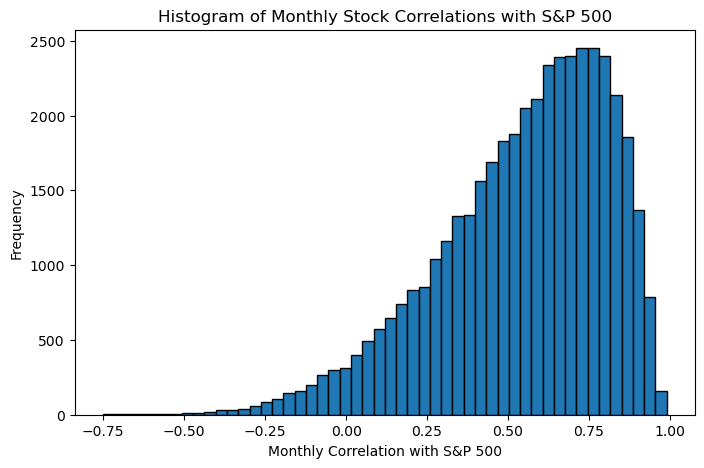

In [8]:
plt.figure(figsize=(8, 5))
plt.hist(monthly_corr['corr_with_sp500'], bins=50, edgecolor='k')
plt.xlabel('Monthly Correlation with S&P 500')
plt.ylabel('Frequency')
plt.title('Histogram of Monthly Stock Correlations with S&P 500')
plt.show()

In [9]:
# merge the per‐month correlations back onto each row
returns_with_corr = df_long.merge(
    monthly_corr,
    on=["PERMNO","month"],
    how="left"
)

# now df_with_corr has a new column 'corr_with_sp500' repeated for every day in that month
returns_with_corr

,PERMNO,date,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,BID,...,SHROUT,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn,avg_impl_vol,month,corr_with_sp500
0,10104,2011-01-03,ORCL,ORACLE CORP,31.52500,31.94000,31.62000,21136353.0,0.010172,31.64000,...,5052420.0,0.010224,0.011212,0.011181,0.012533,0.012516,0.011315,0.218368,2011-01,0.420110
1,10104,2011-01-04,ORCL,ORACLE CORP,31.13500,31.75000,31.48000,22978313.0,-0.004438,31.46000,...,5052420.0,-0.004428,-0.003895,-0.003939,-0.006753,-0.006774,-0.001313,0.219083,2011-01,0.420110
2,10104,2011-01-05,ORCL,ORACLE CORP,30.98000,31.44000,31.04000,36464087.0,-0.014076,31.03000,...,5052420.0,-0.013977,0.005382,0.005299,0.007944,0.007917,0.005007,0.214034,2011-01,0.420110
3,10104,2011-01-06,ORCL,ORACLE CORP,31.02000,31.20000,31.17000,21963429.0,0.004179,31.16000,...,5052420.0,0.004188,-0.002515,-0.002757,-0.001211,-0.001248,-0.002123,0.220563,2011-01,0.420110
4,10104,2011-01-07,ORCL,ORACLE CORP,30.93000,31.34000,31.03000,27819266.0,-0.004501,31.03000,...,5052420.0,-0.004491,-0.001949,-0.001951,-0.002848,-0.002850,-0.001845,0.222230,2011-01,0.420110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902975,92655,2022-12-23,UNH,UNITEDHEALTH GROUP INC,522.89502,531.31000,531.31000,1292327.0,0.007974,531.23999,...,934349.0,0.008006,0.005465,0.005393,0.002459,0.002195,0.005868,0.232563,2022-12,0.476188
902976,92655,2022-12-27,UNH,UNITEDHEALTH GROUP INC,529.84497,535.84003,531.98999,1596719.0,0.001279,531.87000,...,934349.0,0.001280,-0.003930,-0.003999,-0.008489,-0.008633,-0.004050,0.248637,2022-12,0.476188
902977,92655,2022-12-28,UNH,UNITEDHEALTH GROUP INC,527.73401,538.15002,528.45001,1694377.0,-0.006676,528.44000,...,934349.0,-0.006654,-0.012364,-0.012381,-0.010297,-0.010560,-0.012021,0.245414,2022-12,0.476188
902978,92655,2022-12-29,UNH,UNITEDHEALTH GROUP INC,528.85999,533.67999,529.88000,1379681.0,0.002702,529.84003,...,934349.0,0.002706,0.018339,0.018137,0.022834,0.022336,0.017461,0.247116,2022-12,0.476188


In [10]:
# 1) Make sure your VIX DataFrame is keyed by a plain DateTimeIndex
vix.index = pd.to_datetime(vix.index).normalize()

# 2) Map the VIX level into df_with_corr as 'market_vol'
#    (rename the column to something easier)
returns_with_corr['market_vol'] = (
    returns_with_corr['date'].dt.normalize()
                  .map(vix[('VIX', '^VIX')])
)

# 3) Compute beta = (avg_impl_vol * corr_with_sp500) / market_vol
returns_with_corr['beta'] = (
    returns_with_corr['avg_impl_vol'] 
    * returns_with_corr['corr_with_sp500'] 
    / returns_with_corr['market_vol']
)

# 4) Inspect
print(returns_with_corr[['date','PERMNO','avg_impl_vol','corr_with_sp500','market_vol','beta']].head())

        date  PERMNO  avg_impl_vol  corr_with_sp500  market_vol      beta
0 2011-01-03   10104      0.218368          0.42011      0.1761  0.520946
1 2011-01-04   10104      0.219083          0.42011      0.1738  0.529570
2 2011-01-05   10104      0.214034          0.42011      0.1702  0.528308
3 2011-01-06   10104      0.220563          0.42011      0.1740  0.532534
4 2011-01-07   10104      0.222230          0.42011      0.1714  0.544698


In [11]:
returns_with_corr

,PERMNO,date,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,BID,...,vwretd,vwretx,ewretd,ewretx,sprtrn,avg_impl_vol,month,corr_with_sp500,market_vol,beta
0,10104,2011-01-03,ORCL,ORACLE CORP,31.52500,31.94000,31.62000,21136353.0,0.010172,31.64000,...,0.011212,0.011181,0.012533,0.012516,0.011315,0.218368,2011-01,0.420110,0.1761,0.520946
1,10104,2011-01-04,ORCL,ORACLE CORP,31.13500,31.75000,31.48000,22978313.0,-0.004438,31.46000,...,-0.003895,-0.003939,-0.006753,-0.006774,-0.001313,0.219083,2011-01,0.420110,0.1738,0.529570
2,10104,2011-01-05,ORCL,ORACLE CORP,30.98000,31.44000,31.04000,36464087.0,-0.014076,31.03000,...,0.005382,0.005299,0.007944,0.007917,0.005007,0.214034,2011-01,0.420110,0.1702,0.528308
3,10104,2011-01-06,ORCL,ORACLE CORP,31.02000,31.20000,31.17000,21963429.0,0.004179,31.16000,...,-0.002515,-0.002757,-0.001211,-0.001248,-0.002123,0.220563,2011-01,0.420110,0.1740,0.532534
4,10104,2011-01-07,ORCL,ORACLE CORP,30.93000,31.34000,31.03000,27819266.0,-0.004501,31.03000,...,-0.001949,-0.001951,-0.002848,-0.002850,-0.001845,0.222230,2011-01,0.420110,0.1714,0.544698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902975,92655,2022-12-23,UNH,UNITEDHEALTH GROUP INC,522.89502,531.31000,531.31000,1292327.0,0.007974,531.23999,...,0.005465,0.005393,0.002459,0.002195,0.005868,0.232563,2022-12,0.476188,0.2087,0.530637
902976,92655,2022-12-27,UNH,UNITEDHEALTH GROUP INC,529.84497,535.84003,531.98999,1596719.0,0.001279,531.87000,...,-0.003930,-0.003999,-0.008489,-0.008633,-0.004050,0.248637,2022-12,0.476188,0.2165,0.546874
902977,92655,2022-12-28,UNH,UNITEDHEALTH GROUP INC,527.73401,538.15002,528.45001,1694377.0,-0.006676,528.44000,...,-0.012364,-0.012381,-0.010297,-0.010560,-0.012021,0.245414,2022-12,0.476188,0.2214,0.527836
902978,92655,2022-12-29,UNH,UNITEDHEALTH GROUP INC,528.85999,533.67999,529.88000,1379681.0,0.002702,529.84003,...,0.018339,0.018137,0.022834,0.022336,0.017461,0.247116,2022-12,0.476188,0.2144,0.548852


In [12]:
returns_with_corr[["date", "PERMNO", "beta"]].to_parquet("beta.parquet")